In [50]:
import importlib
import os, pandas as pd, numpy as np
from joblib import dump, load

import sys
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
import sod.core.dataset as sod_core_dataset
importlib.reload(sod_core_dataset)
import sod.core.plot as sod_plot
importlib.reload(sod_plot)
# from sod.core.dataset import open_dataset # , normalize_df
# from sod import plot

is_outlier = sod_core_dataset.is_outlier

maindir = os.path.abspath(os.path.join(os.getcwd(), '..', 'evaluations/results/cv.allset_train.iforest.2.yaml/evalreports/'))
assert os.path.isdir(maindir)

# THIS ASSUMES YOU ALREADY CREATED THE EVALUATIIN AGGREGATION. SEE AGGREGAT.EVALUATIONS
path = os.path.join(maindir, 'evaluations.all.hdf')


dfr = pd.read_hdf(path)
print('evaulation dataframe.\n\nColumns:\n' + str(dfr.columns.tolist()))
print('\nclassname distinct values:\n' + str(np.unique(dfr['classname'])))

evaulation dataframe.

Columns:
['% rec.', 'Mean log_loss', 'behaviour', 'classname', 'clf', 'contamination', 'features', 'max_samples', 'n_estimators']

classname distinct values:
['ok' 'outl. (wrong inv)' 'unlabeled (Me suspicious outl.)'
 'unlabeled (Me unknown)']


INPECTING SCORES FOR CLASS: outl. (wrong inv)


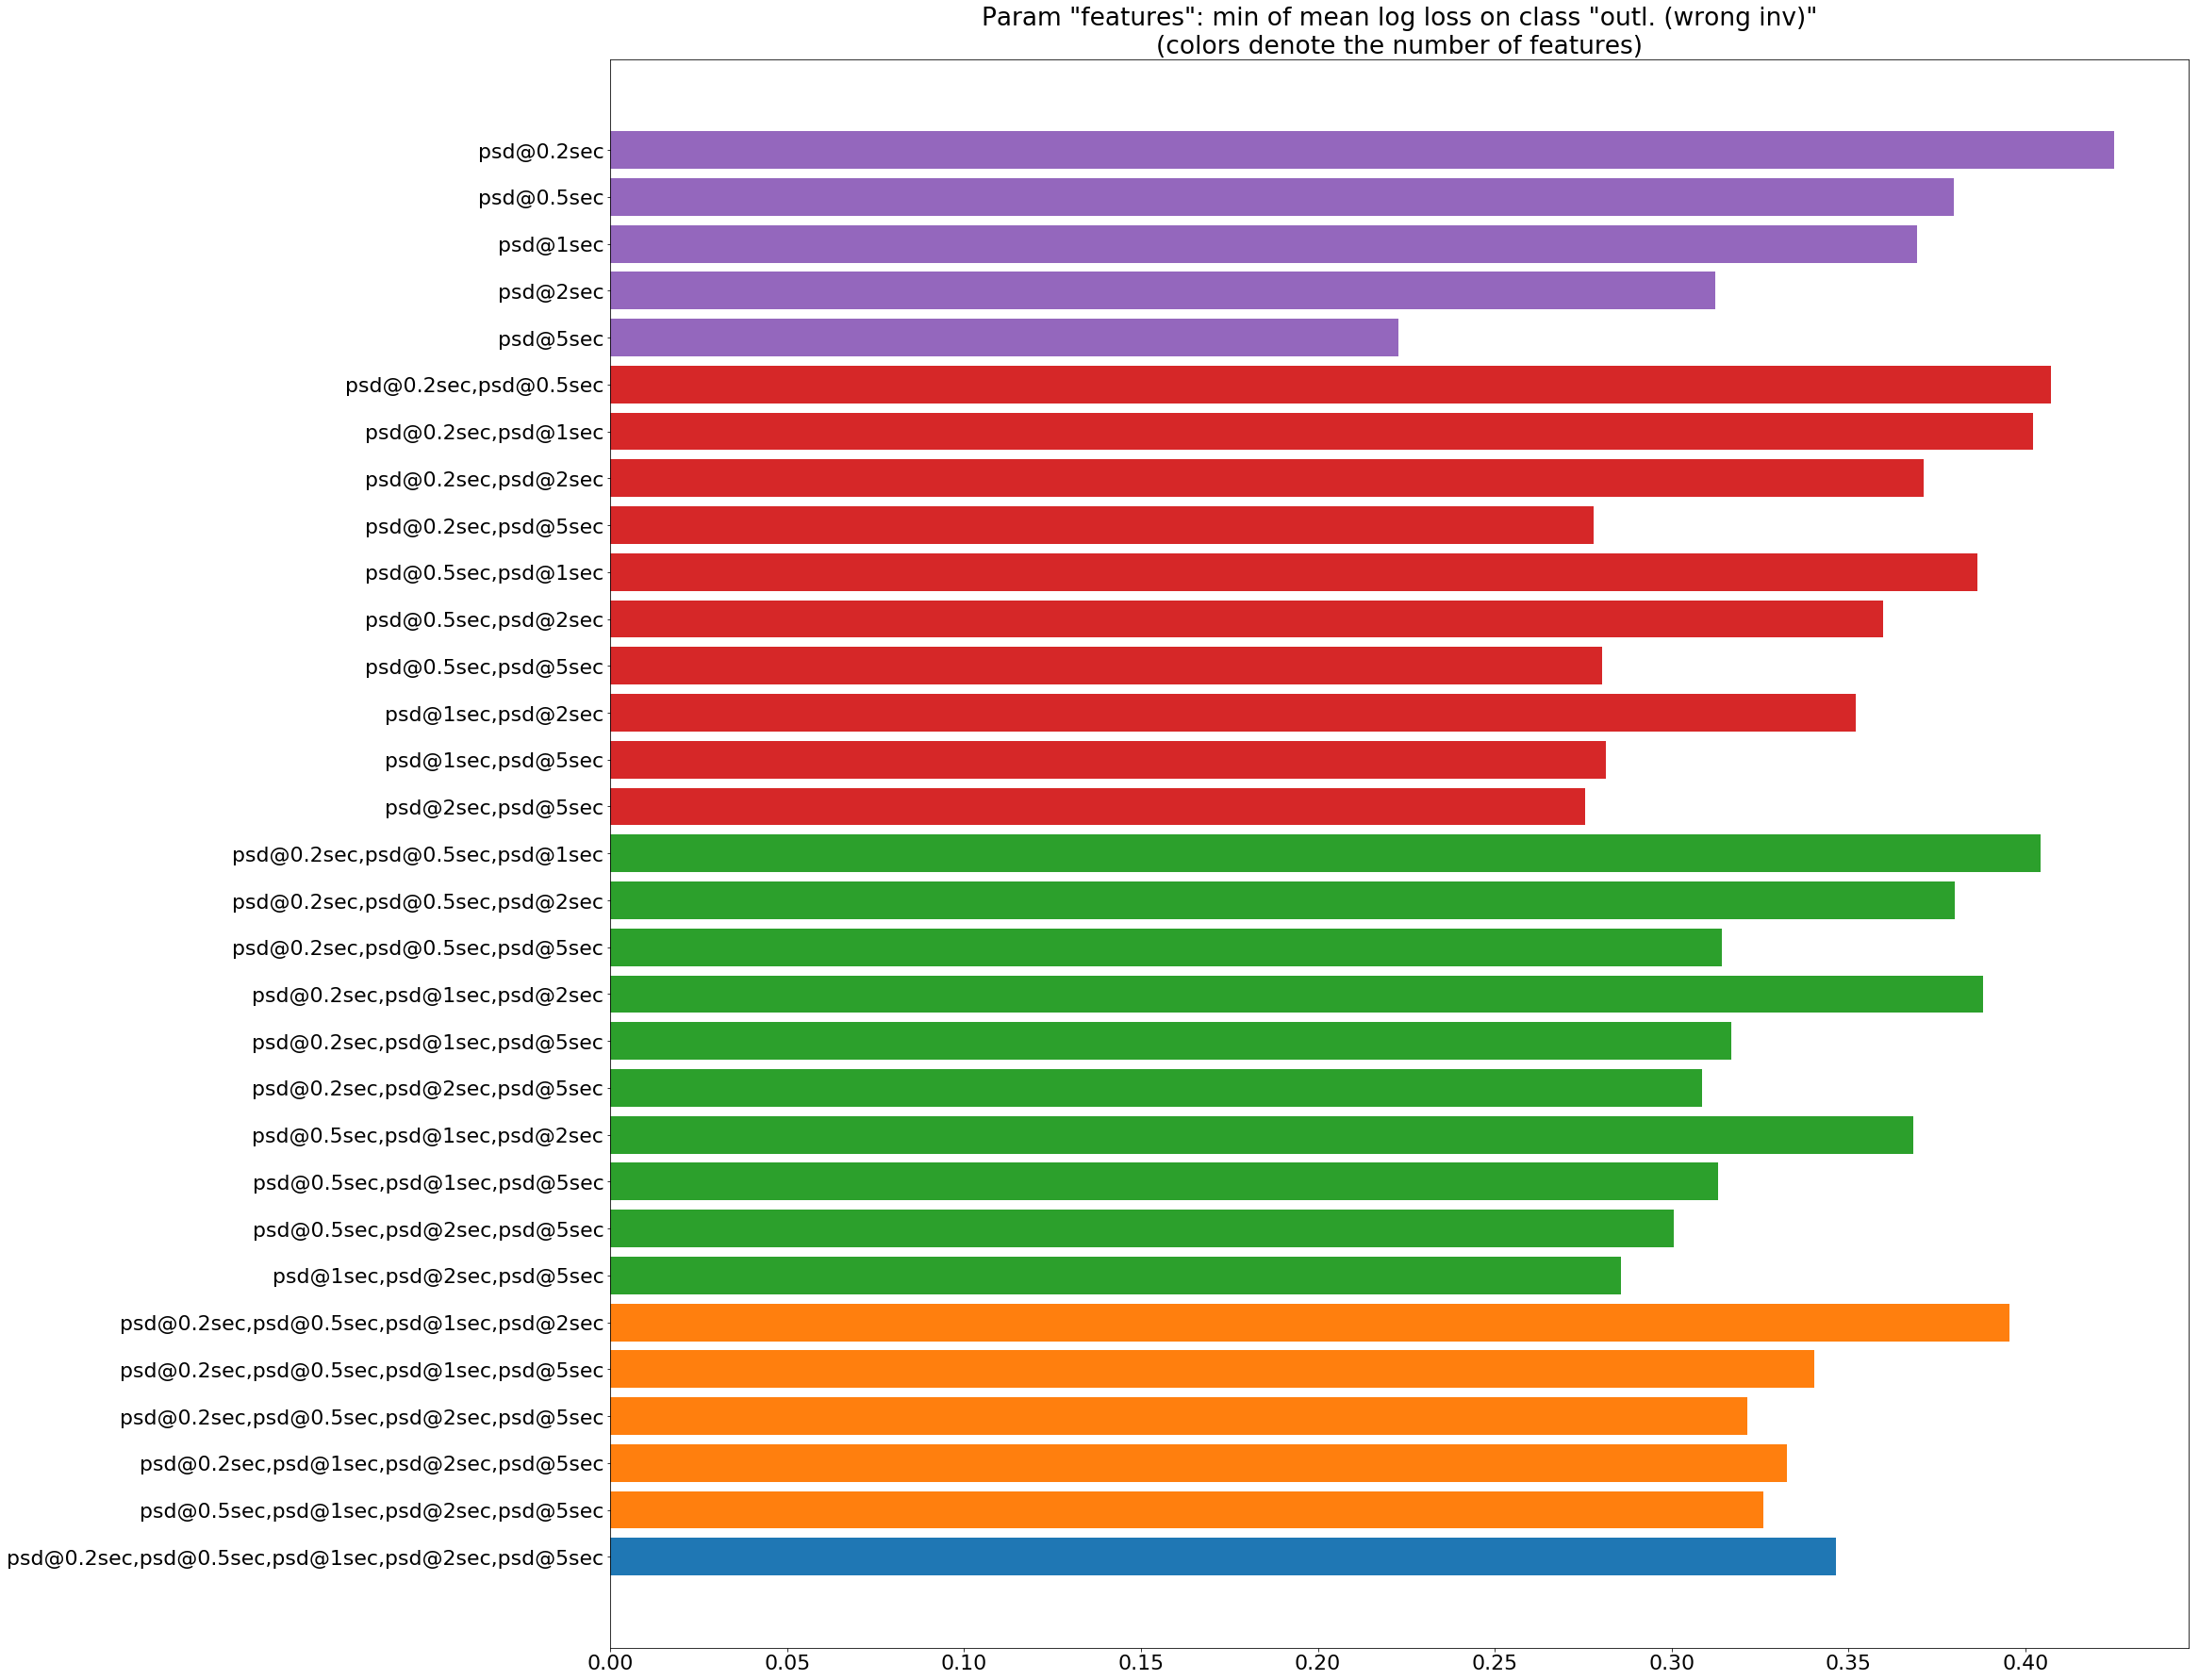

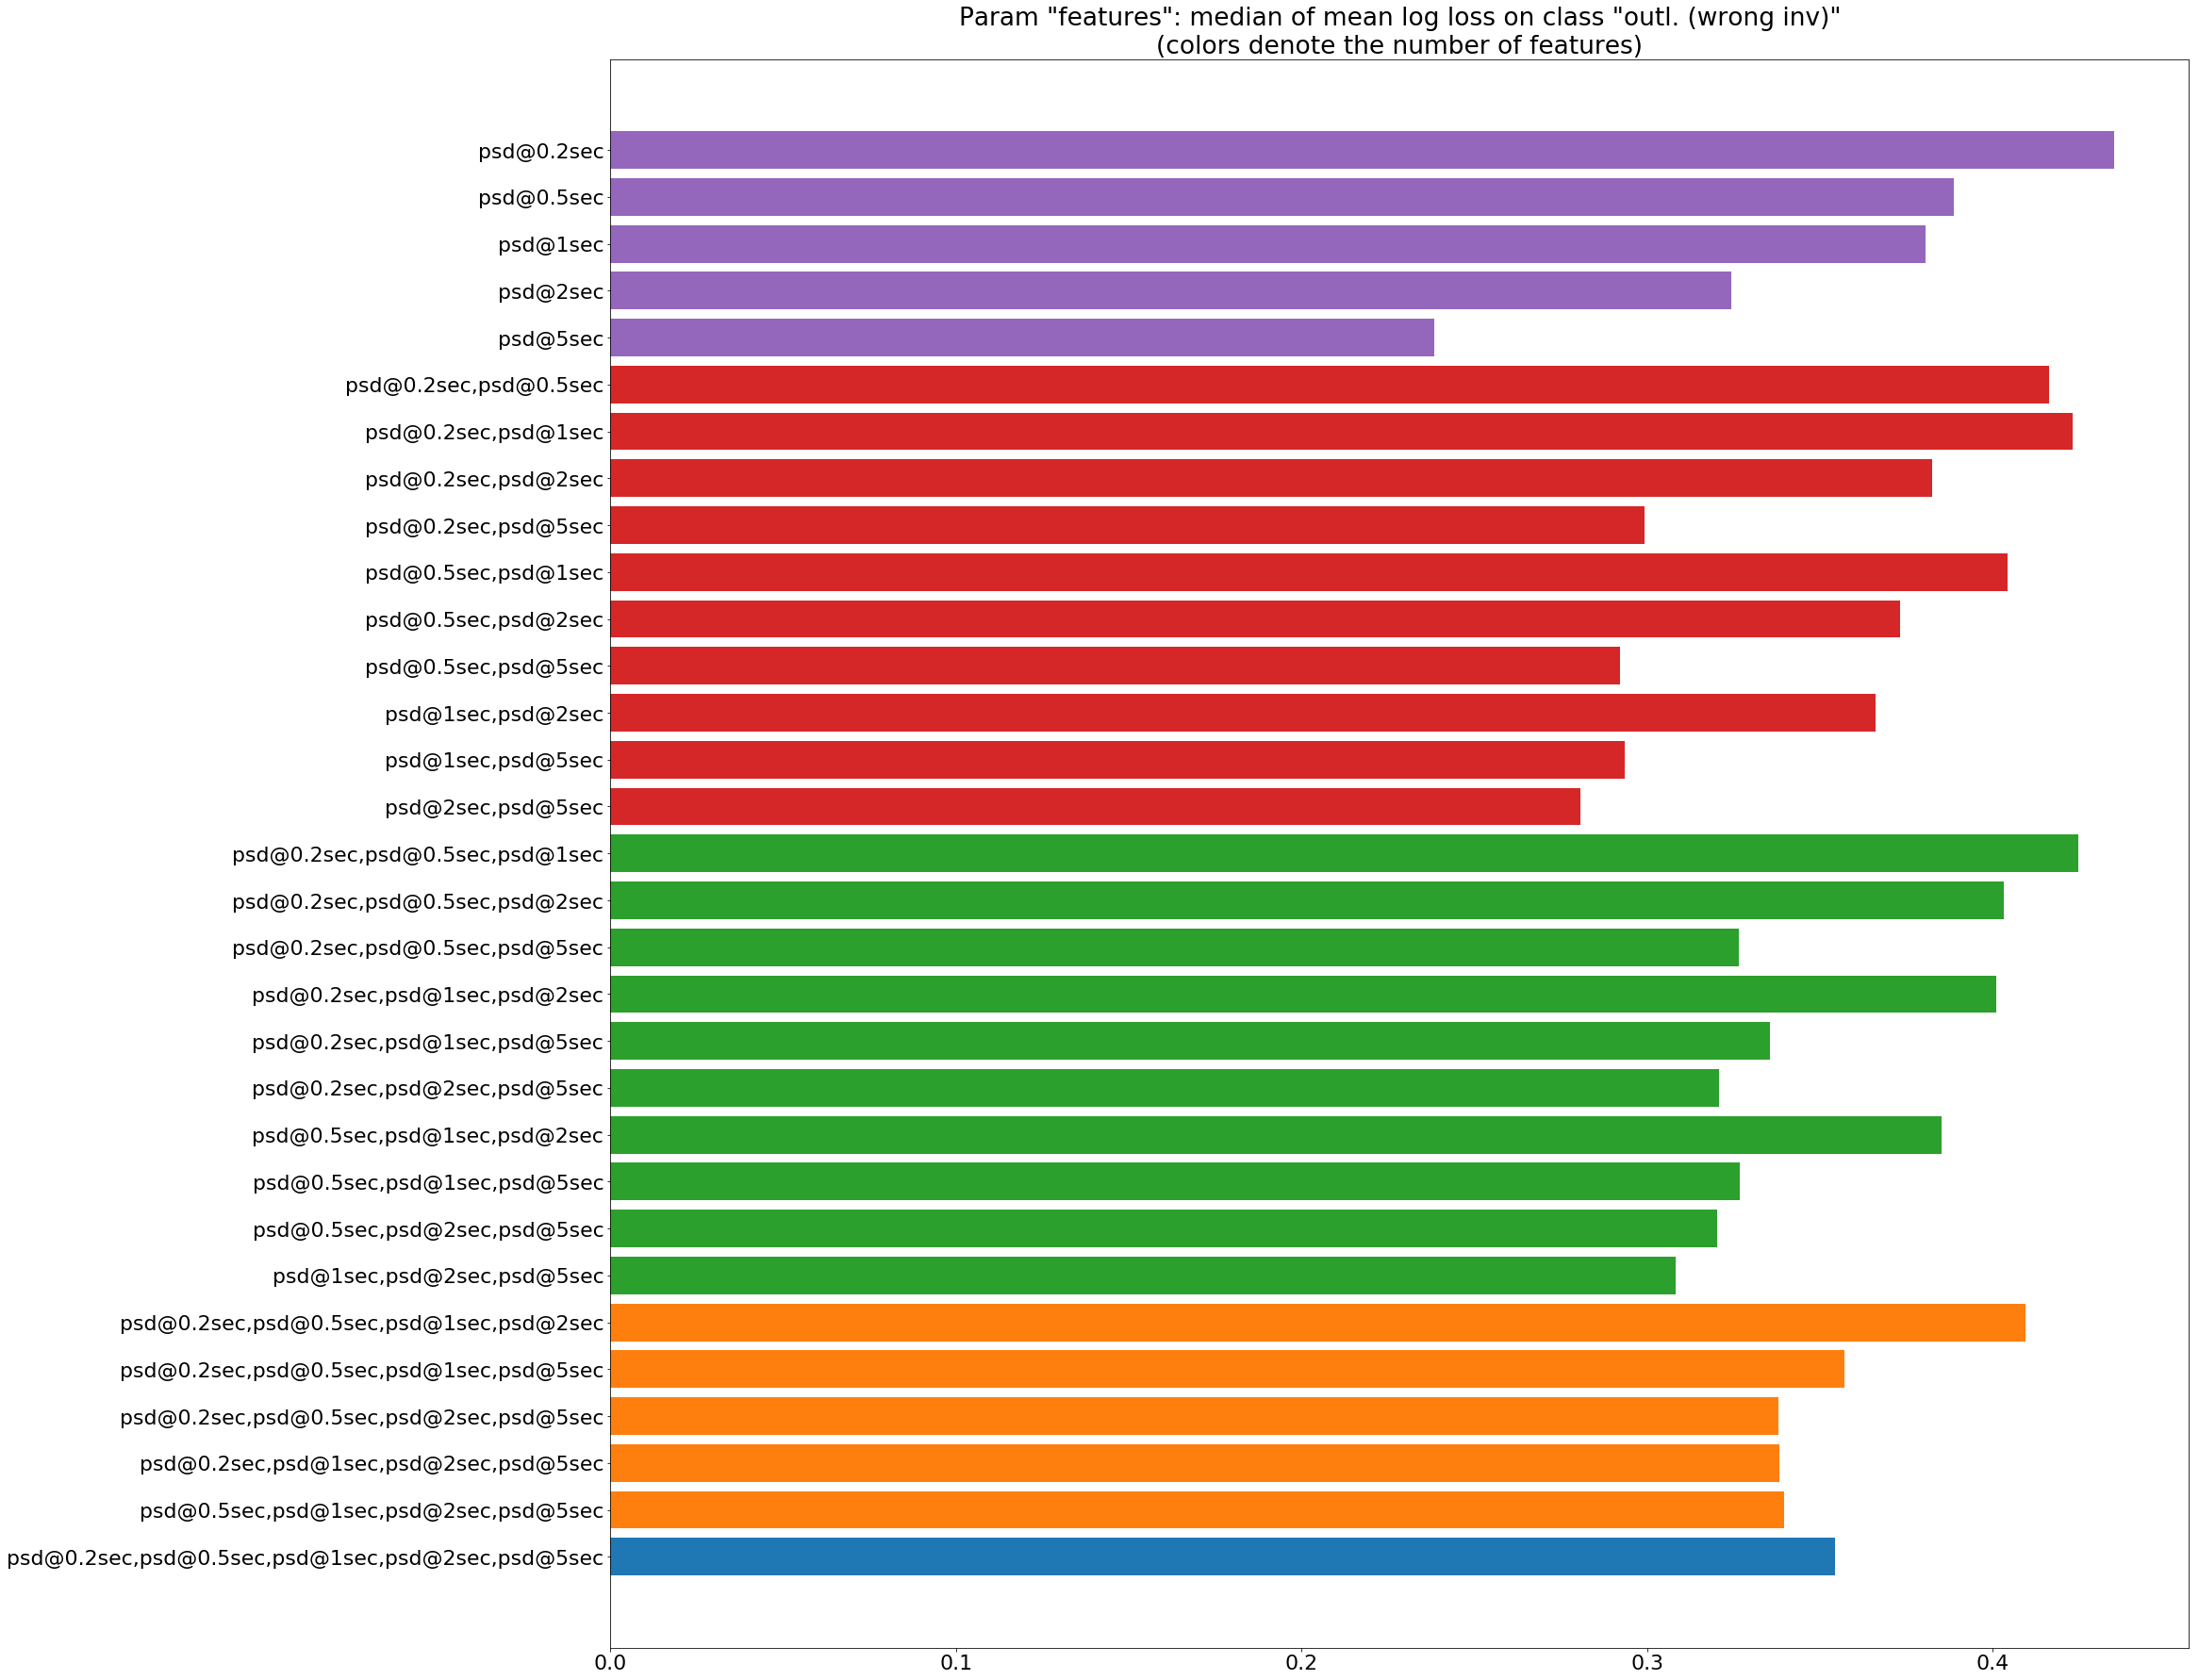

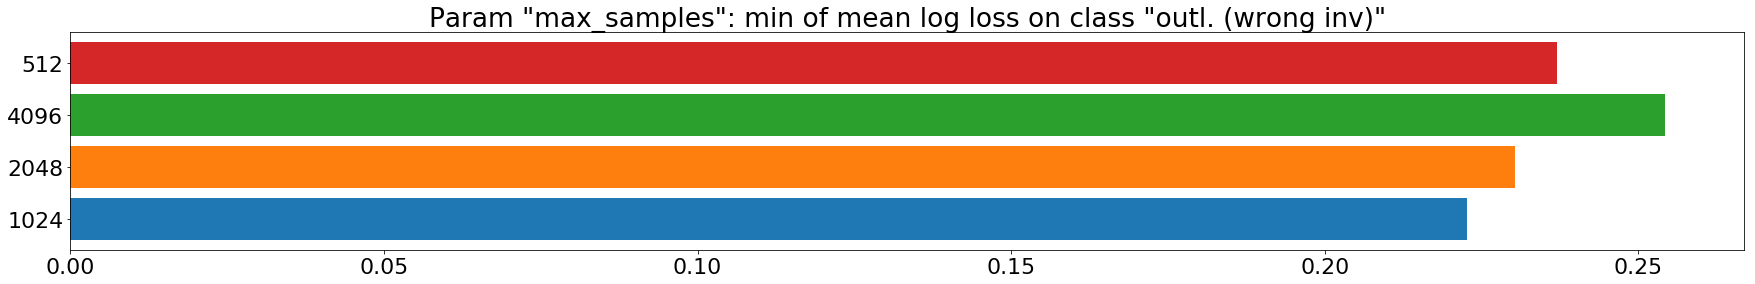

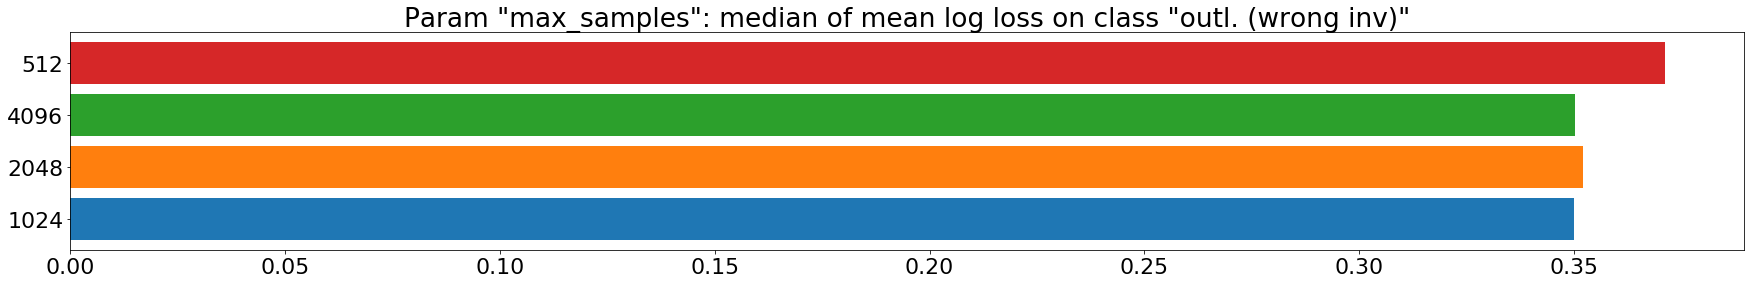

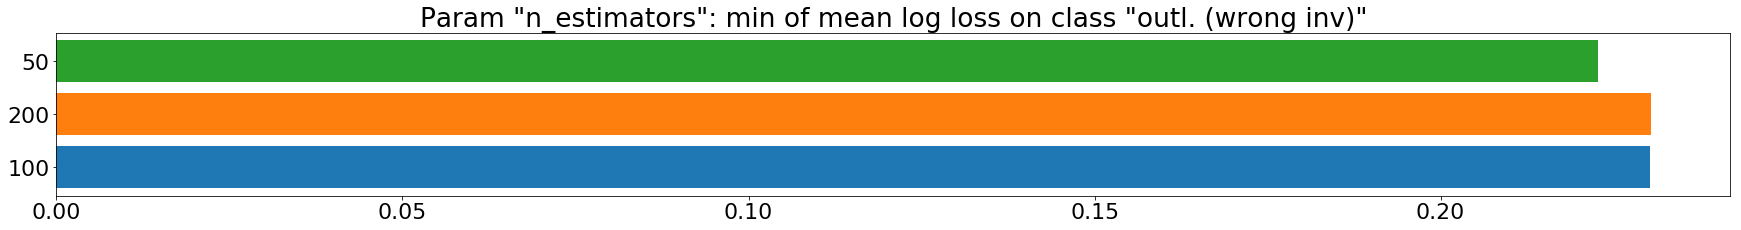

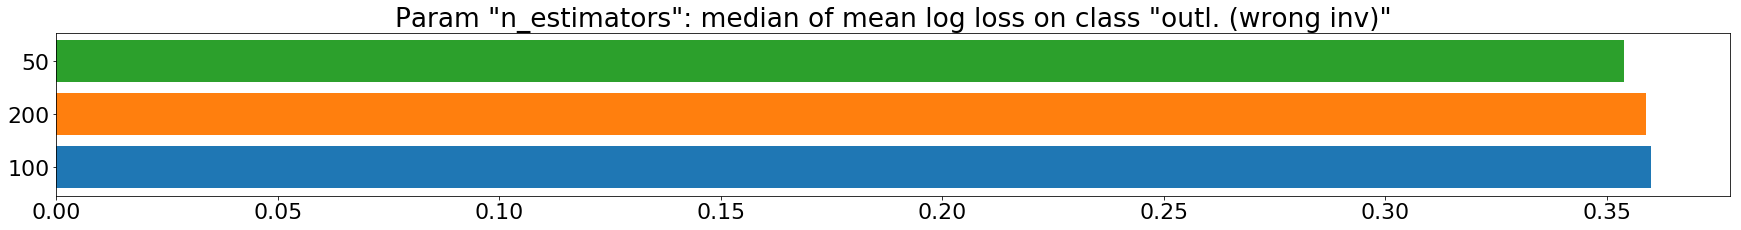


INPECTING SCORES FOR CLASS: ok


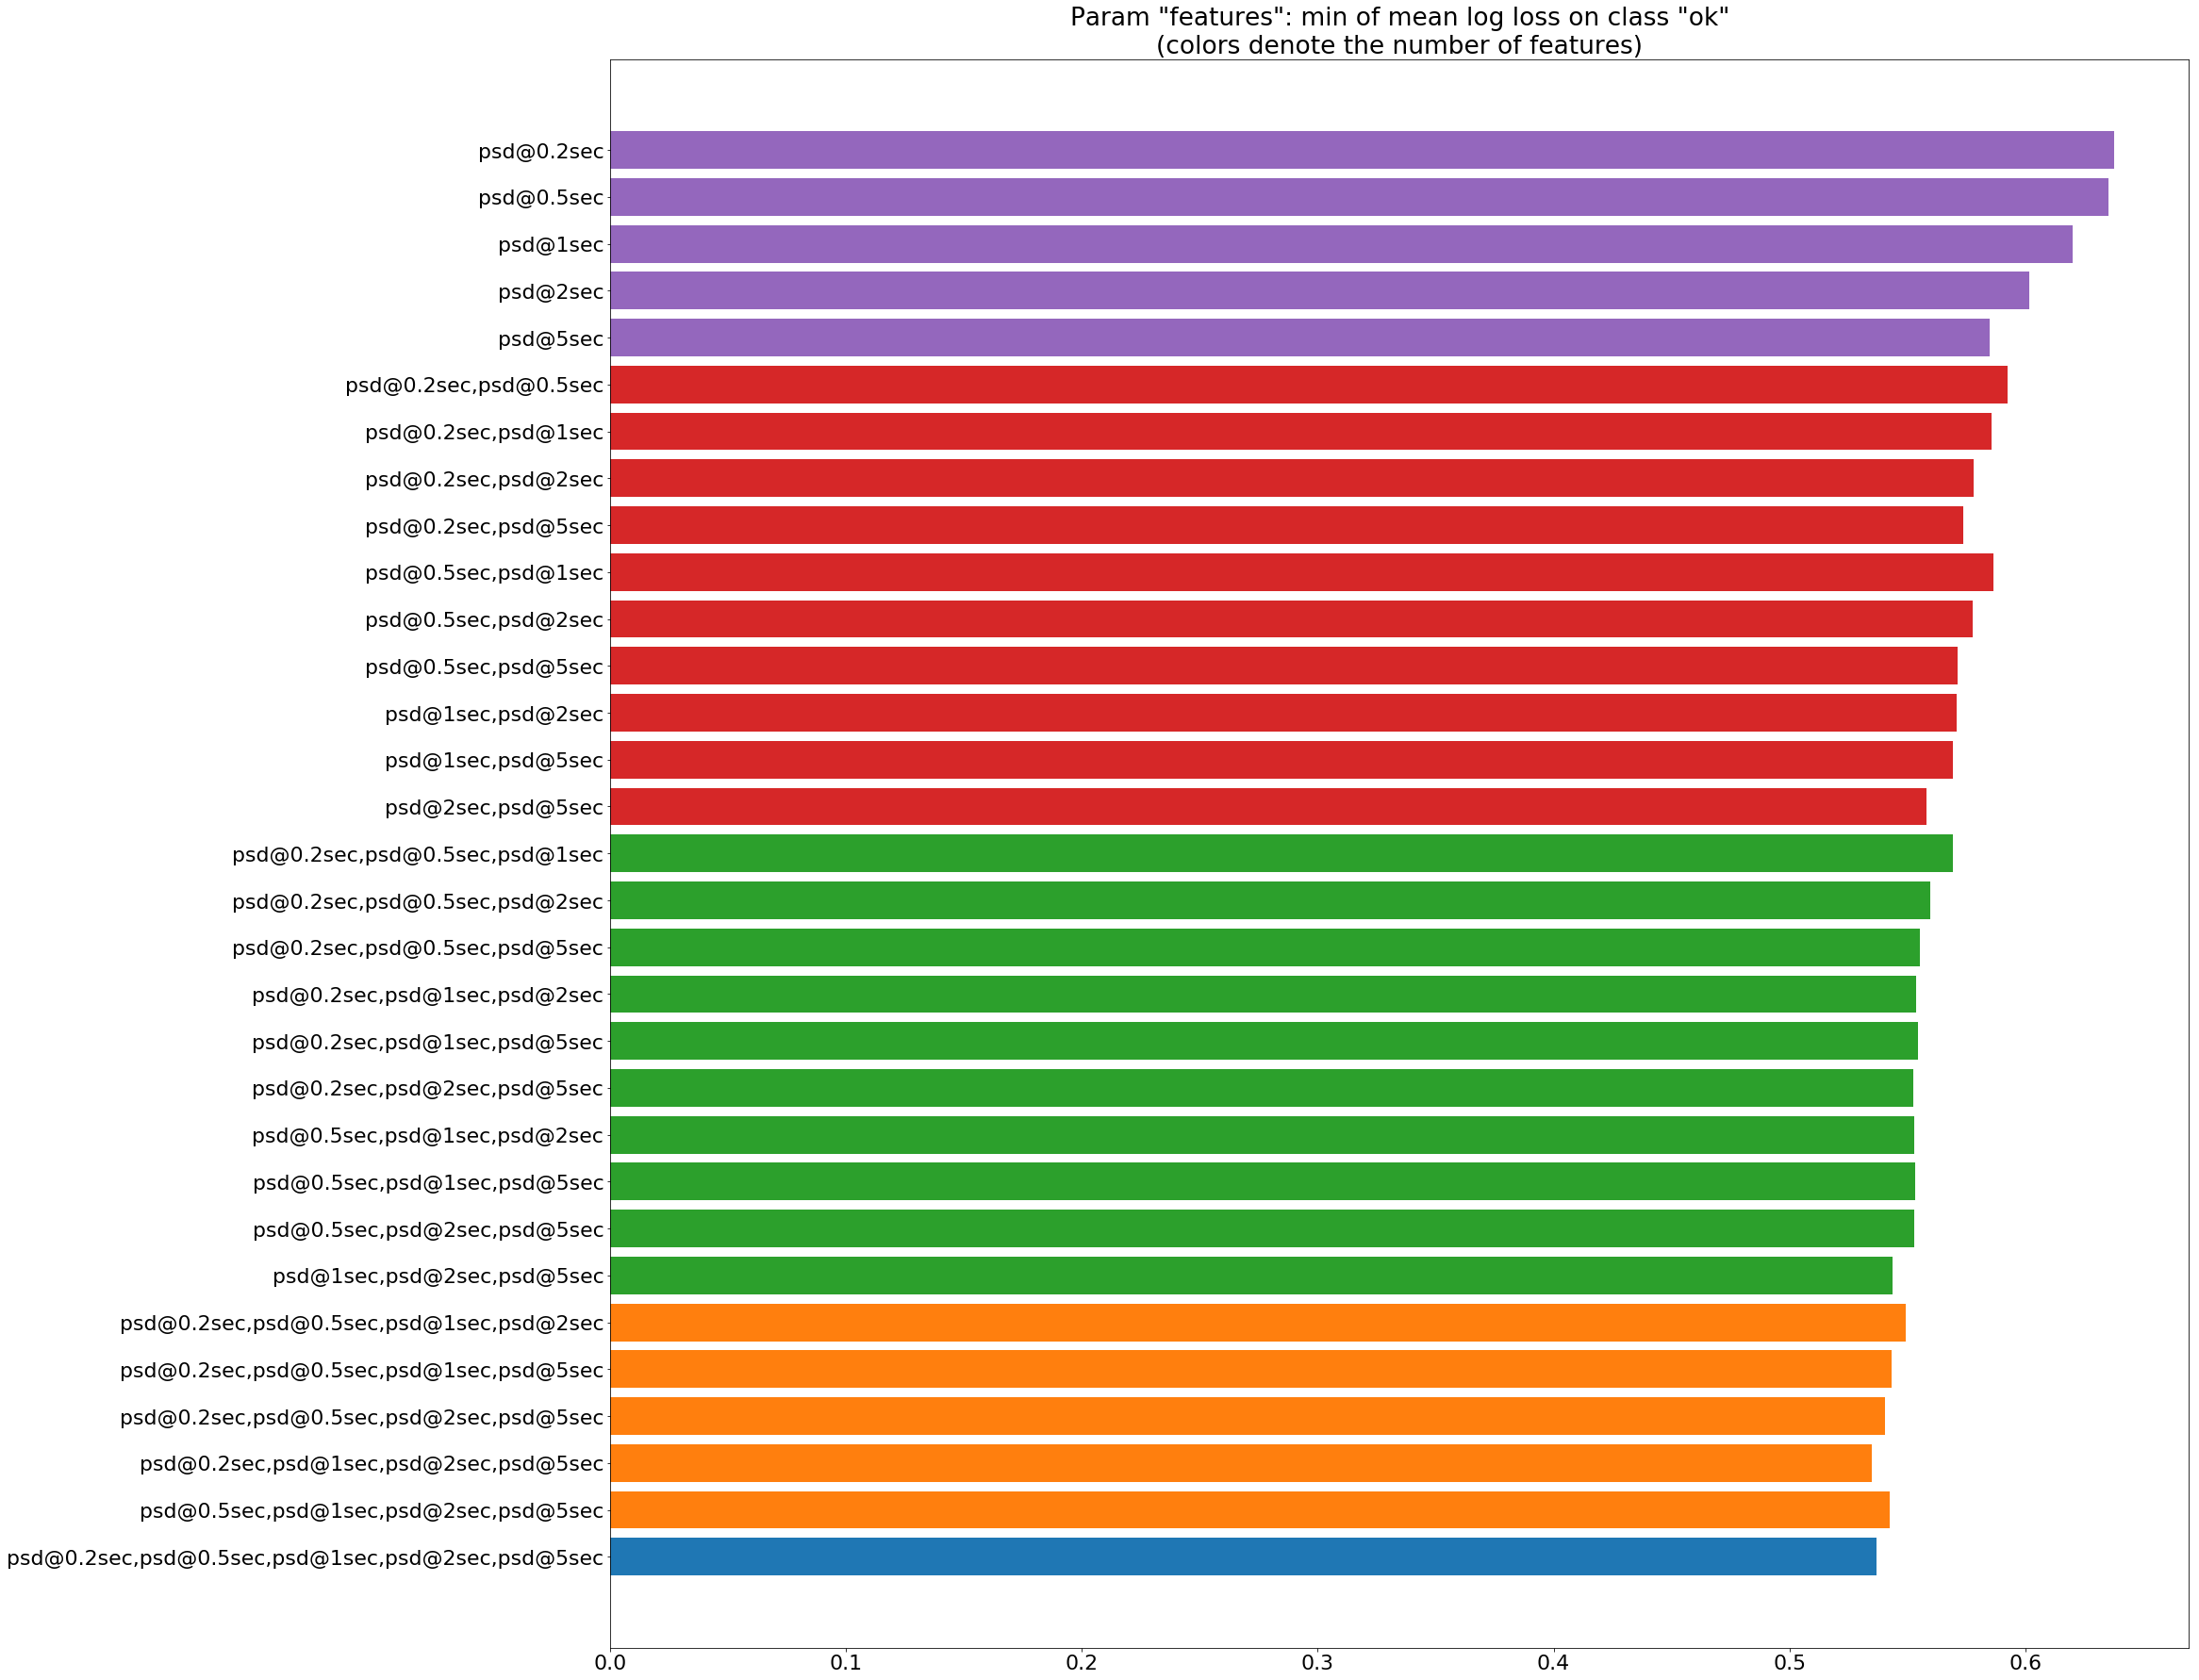

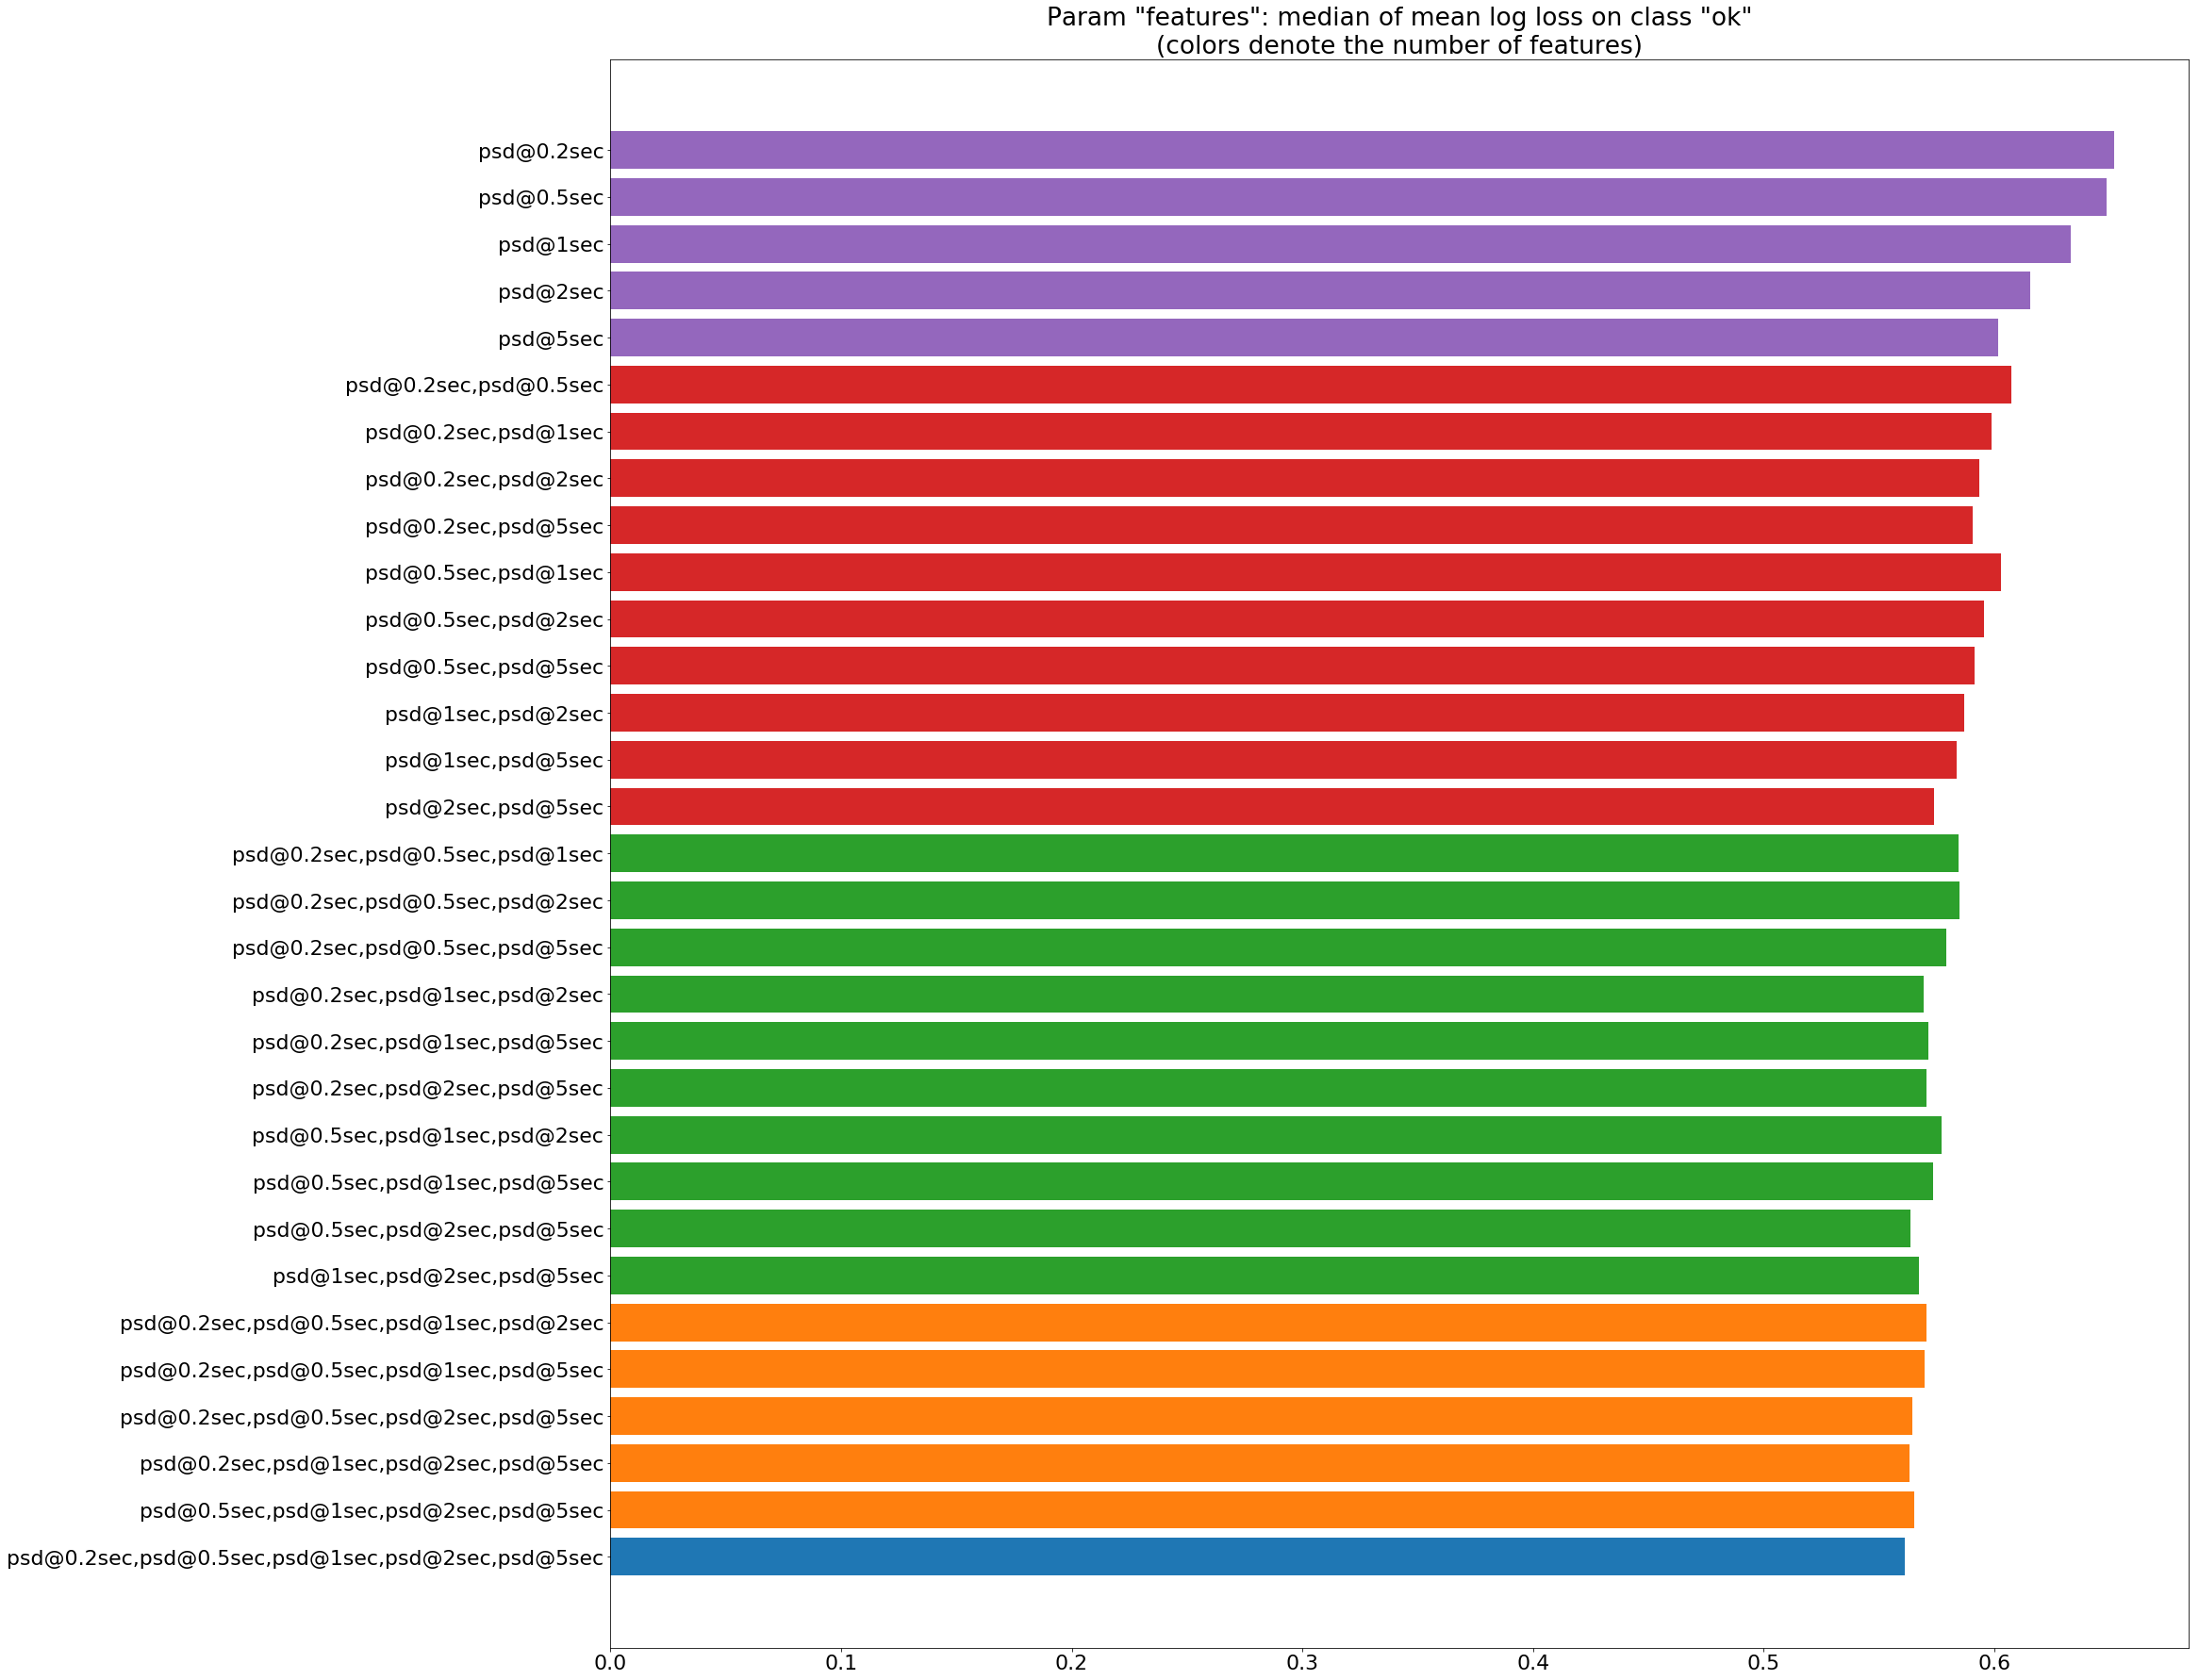

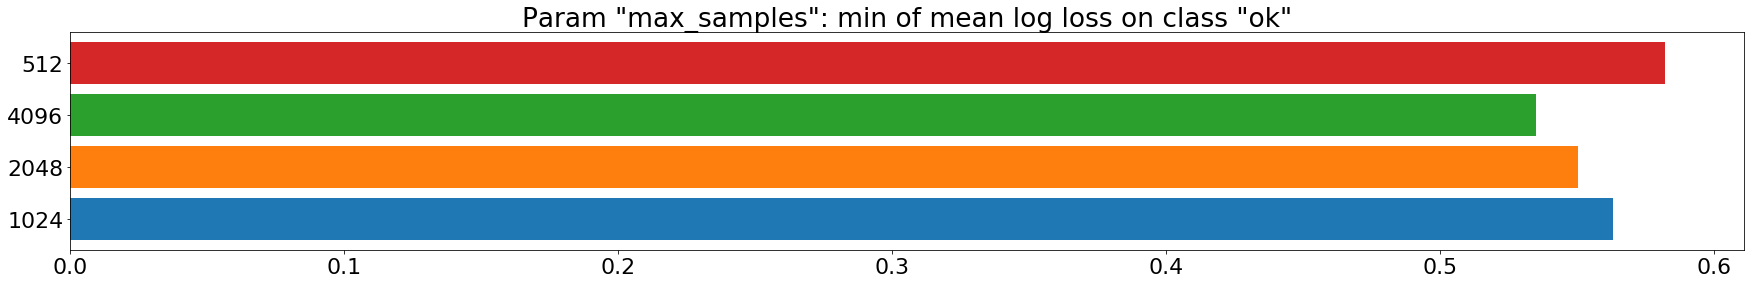

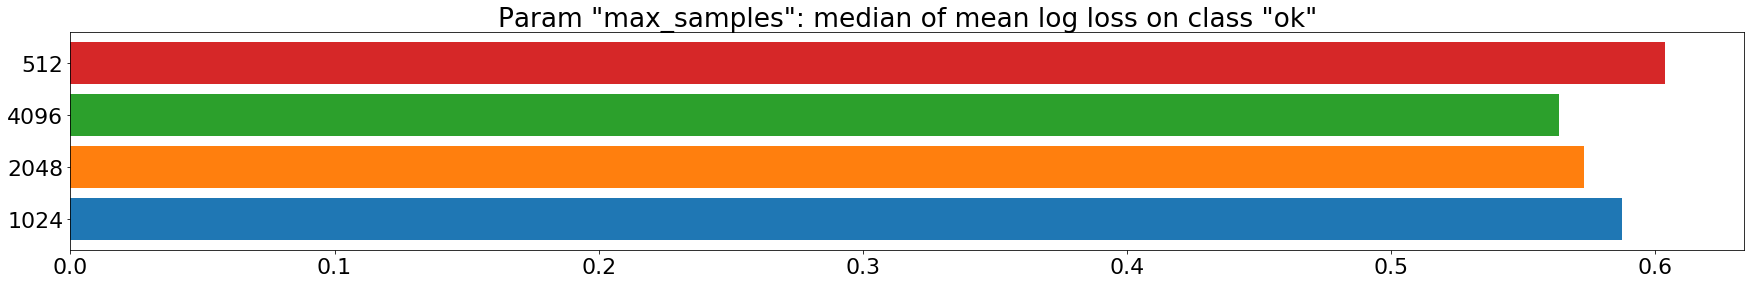

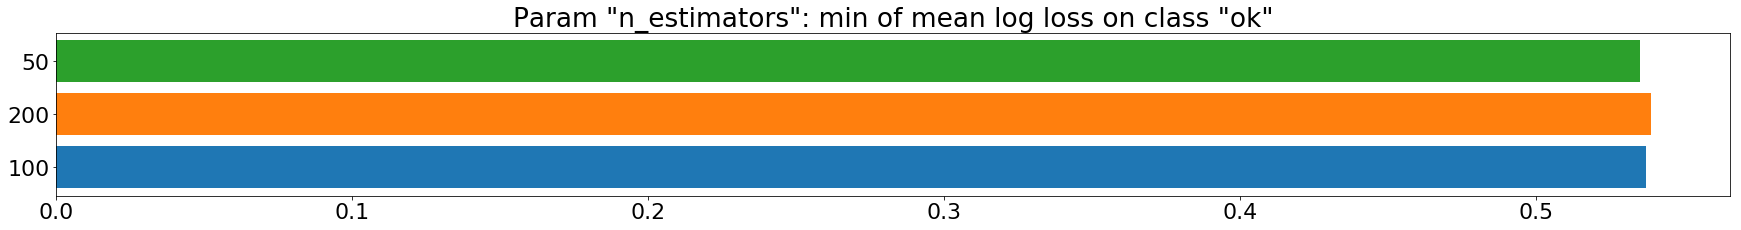

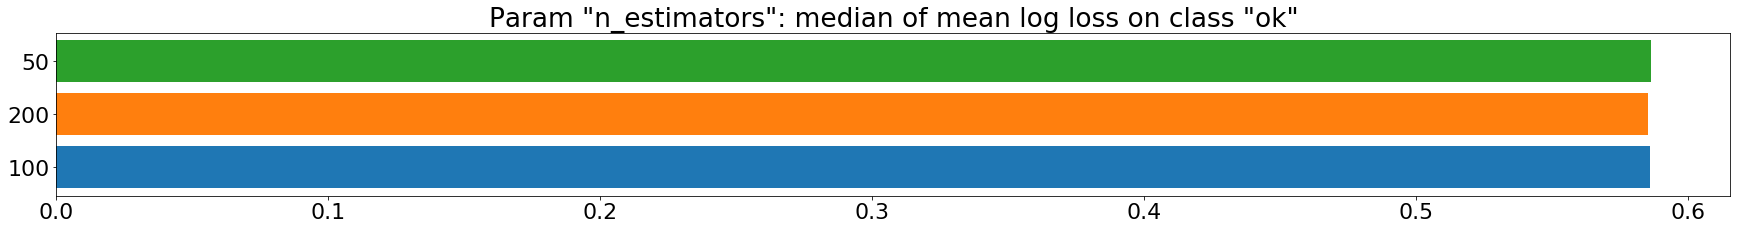

In [52]:
import matplotlib
importlib.reload(matplotlib)
import numpy as np
import matplotlib.pyplot as plt
from contextlib import contextmanager
from collections import defaultdict

%matplotlib inline

@contextmanager
def plotparams(params):
    '''makes temporarily matplotlib params.
    Make sure to run this after %matplotlib inline.
    For info see https://stackoverflow.com/questions/36367986/how-to-make-inline-plots-in-jupyter-notebook-larger'''
    def_params = {k: plt.rcParams[k] for k in params}
    for k, v in params.items():
        plt.rcParams[k] = v
    try:
        yield
    finally:
        for k, v in def_params.items():
            plt.rcParams[k] = v

# tmp_fig_size = matplotlib.rcParams['figure.figsize']
# matplotlib.rcParams['figure.figsize']
# plt.rcParams.update({'font.size': 30})
# plt.rcParams.update({'figure.figsize': (22, 22)})


class_ = 'outl. (wrong inv)'

from itertools import cycle
basecolors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

columns = ['features', 'max_samples', 'n_estimators']


for class_ in ['outl. (wrong inv)', 'ok']:
    print('INPECTING SCORES FOR CLASS: %s' % class_)
    for col in columns:

        colors_ = iter(cycle(basecolors))
        colorsdict = defaultdict(lambda: next(colors_))

        data = defaultdict(list)
        for _, df_ in dfr.groupby(col):
            data[_].extend(_ for _ in df_[df_.classname == class_]['Mean log_loss'])

        if col == 'features':
            labels = sorted(data.keys(), key=lambda f: (len(f.split(',')), f), reverse=True)
            colors = [colorsdict[len(_.split(','))] for _ in labels]
            labelcap = '\n(colors denote the number of features)'
        else:
            labels = sorted((_ for _ in data), key=str)
            colors = [colorsdict[_] for _ in labels]
            labelcap = ''

        size = len(data)
        with plotparams({'figure.figsize': (30, size), 'font.size': 22}):

            avg = {_: np.nanmin(data[_]) for _ in data}
            ypos = np.arange(len(labels))
            plt.barh(ypos, [avg[_] for _ in labels], align='center', color=colors)
            plt.title('Param "%s": min of mean log loss on class "%s"%s' % (col, class_, labelcap))
            plt.gca().set_yticks(ypos)
            plt.gca().set_yticklabels(labels)

            plt.show()

            avg = {_: np.quantile(data[_], 0.5) for _ in data}
            ypos = np.arange(len(labels))
            plt.barh(ypos, [avg[_] for _ in labels], align='center', color=colors)
            plt.title('Param "%s": median of mean log loss on class "%s"%s' % (col, class_, labelcap))
            plt.gca().set_yticks(ypos)
            plt.gca().set_yticklabels(labels)

            plt.show()

            print()

    # print(pd.Series(avg))

In [10]:
root = os.path.abspath(os.path.join(os.getcwd(), '..', 'evaluations', 'results', 'cv.allset_train.iforest.2.yaml'))
assert(os.path.isdir(root))
import pandas as pd

# adding the two best with two features, with contamination 5% an 10%
fnames = {
    'psd[.2,1,2,5] psi=4096 t=50': 'IsolationForest?features=psd@0.2sec,psd@1sec,psd@2sec,psd@5sec&contamination=auto&max_samples=4096&n_estimators=50&behaviour=new',
    'psd[5] psi=1024 50': 'IsolationForest?features=psd@5sec&contamination=auto&max_samples=1024&n_estimators=50&behaviour=new',
    #'cont10%, samples2048': 'IsolationForest?features=psd@2sec,psd@5sec&contamination=0.1&max_samples=2048&n_estimators=200&behaviour=new',
    #'cont5%, samples512': 'IsolationForest?features=psd@2sec,psd@5sec&contamination=0.05&max_samples=512&n_estimators=200&behaviour=new',
}


clfs = {k: load(os.path.join(root, 'models', v + '.model')) for k, v in fnames.items()}
pred_dfs = {k: pd.read_hdf(os.path.join(root, 'predictions', v + '.hdf')) for k, v in fnames.items()}

for n, c in clfs.items():
    print('%s: %s' % (str(n), str(c)))

# print('loading source trainset')
# dataframe = sod_core_dataset.open_dataset('allset_train.hdf', normalize=False, verbose=False)

psd[.2,1,2,5] psi=4096 t=50: IsolationForest(behaviour='new', bootstrap=False, contamination='auto',
                max_features=1.0, max_samples=4096, n_estimators=50,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)
psd[5] psi=1024 50: IsolationForest(behaviour='new', bootstrap=False, contamination='auto',
                max_features=1.0, max_samples=1024, n_estimators=50,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)
loading source trainset


SCORES DISTRIBUTIONS ON SEGMENTS: INLIERS + OUTLIERS + ME UNKNOWN
psd[.2,1,2,5] psi=4096 t=50


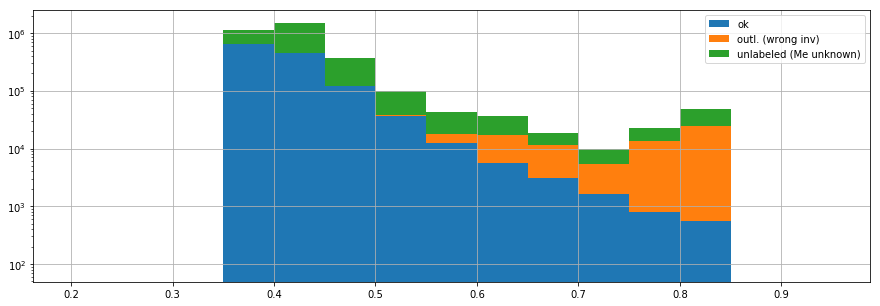

psd[5] psi=1024 50


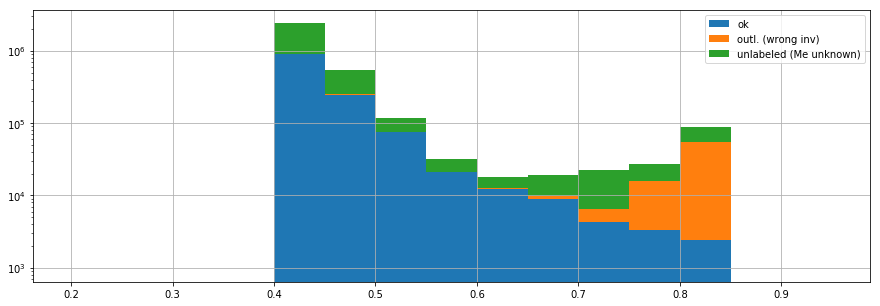

In [92]:
from sod.core.dataset import dataset_info, allset_train

dinfo = dataset_info(dataframe)

class_inlier = allset_train.classnames[0]
class_outlier = allset_train.classnames[1]
class_me_suspicious = allset_train.classnames[2]
class_me_unknown = allset_train.classnames[3]

sel_inlier = allset_train.class_selector[class_inlier]
sel_outlier = allset_train.class_selector[class_outlier]
sel_me_suspicious = allset_train.class_selector[class_me_suspicious]
sel_me_unknown = allset_train.class_selector[class_me_unknown]


import importlib
import sod.core.plot as sod_plot
importlib.reload(sod_plot)

print('SCORES DISTRIBUTIONS ON SEGMENTS: INLIERS + OUTLIERS + ME UNKNOWN')

%matplotlib inline
import numpy as np
bins = np.arange(0.2, 1, 0.05)
with plotparams({'figure.figsize': (15, 5)}):
    for name, pred_df in pred_dfs.items():
        print(name)
        data = [
            pred_df[sel_inlier(pred_df)].predicted_anomaly_score,
            pred_df[sel_outlier(pred_df)].predicted_anomaly_score,
            pred_df[sel_me_unknown(pred_df)].predicted_anomaly_score
        ]
        
        plt.hist(data, bins=bins, log=True, histtype='bar', stacked=True, label=[class_inlier, class_outlier, class_me_unknown])
        plt.grid()
        # plt.ylim([0, 10**7])
        plt.legend()
        plt.show()

In [93]:
# [1] IF YOU WANT TO SET OUTLIERS THE SEGMENTS BASED ON A HEURISTIC (MEDIAN SCORE_SAMPLES >= 0.8)
# OR ALL SCORE_SAMPLES > 0.5), UNCOMMENT THE LINES BELOW UNTIL [2]:

from collections import defaultdict

print('Taking Me unlabelled segments only')
me_pred_dfs = {n: p[sel_me_suspicious(p) | sel_me_unknown(p)] for n, p in pred_dfs.items()}

outl_staids = defaultdict(int)
inl_staids = defaultdict(int)
print('Getting stations clearly outliers and clearly inliers')
for name, _pred_df in me_pred_dfs.items():
    for station_id, df_ in _pred_df.groupby(['station_id']):
        #if (df_.predicted_anomaly_score > 0.5).all() and df_.predicted_anomaly_score.median() >= 0.7:
        if df_.predicted_anomaly_score.median() >= 0.75:
             outl_staids[station_id] += 1
        #elif (df_.predicted_anomaly_score < 0.55).all():
        elif df_.predicted_anomaly_score.median() <= 0.55:
            inl_staids[station_id] += 1

# take only the staids common to all pred_df:
outl_staids = {k :v for k, v in outl_staids.items() if v == len(me_pred_dfs)}
print('Station ids whose segments have to be set as outliers:')
o_staids = list(outl_staids.keys())
print(o_staids)

inl_staids = {k :v for k, v in inl_staids.items() if v == len(me_pred_dfs)}
print('Station ids whose segments are CLEARLY inliers:')
i_staids = list(inl_staids.keys())
print(i_staids)

# Create a new dict of pred_dfs: 
# preds = {}
# for name, pred_df in pred_dfs.items():
#     preds[name] = pred_df[pred_df.station_id.isin(i_staids) | pred_df.station_id.isin(o_staids)].copy()

# ===========================================================================
# [2] IF YOU WANT TO SET OUTLIERS THE SEGMENTS OF THE STATION IDS CALCULATED
# VIA THE COMMENTED CODE ABOVE, UNCOMMENT THE LINES BELOW:
# staids = [640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 656, 657, 658, 659, 660, 661, 662, 663, 712, 713, 714, 715, 716, 718, 719, 722, 723, 724, 725, 726, 727, 728, 729, 730, 1070, 1071, 1096, 1342, 1412, 1414, 1421, 1422, 1423, 1430, 1431, 1432, 1433, 1443, 1449, 1451, 1453, 1454, 1980, 1990, 1993, 1997, 2410, 2772, 2860, 2861, 2863, 2864, 2904, 3541, 3714, 3715, 3716, 3717, 3727, 3728, 3729, 3730, 3731]

import sod.core.dataset as sod_core_eval
importlib.reload(sod_core_eval)


print('AUTOMATIC RELABELLING OF ME unlabelled segments')
me_preds = {}
for name, _pred_df in me_pred_dfs.items():
    pred_df = _pred_df.copy()
    pred_df['outlier'] = False
    new_outliers =  pred_df.station_id.isin(o_staids)
    pred_df.loc[new_outliers, 'outlier'] = True
    pred_df.loc[new_outliers, 'subclass'] = ''  # see globalset class in sod.core.dataset
    
    new_inliers = pred_df.station_id.isin(i_staids)
    pred_df.loc[new_inliers, 'outlier'] = False
    pred_df.loc[new_inliers, 'subclass'] = ''  # see globalset class in sod.core.dataset
    
    pred_df.loc[(~new_inliers) & (~new_outliers), 'outlier'] = False
    pred_df.loc[(~new_inliers) & (~new_outliers), 'subclass'] = 'unlabeled.unknown'
    
    me_preds[name] = pred_df  # this marks all as outliers, see globalset class in sod.core.dataset


Taking Me unlabelled segments only
Getting stations clearly outliers and clearly inliers
Station ids whose segments have to be set as outliers:
[623, 712, 713, 714, 715, 716, 719, 724, 725, 726, 730, 1061, 1070, 1071, 1096, 1414, 1422, 1423, 1430, 1431, 1432, 1433, 1443, 1449, 1451, 1453, 1454, 2687, 2732, 2904, 2990, 3494, 3645, 3727, 3728, 3729, 3730, 3731]
Station ids whose segments are CLEARLY inliers:
[1, 6, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 63, 64, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 104, 105, 106, 107, 108, 109, 111, 112, 113, 114, 115, 116, 118, 119, 120, 121, 122, 123, 124, 127, 128, 129, 130, 131, 132, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 155

In [94]:
import sod.core.evaluation as sod_core_eval
importlib.reload(sod_core_eval)

def print_cm(prediction_dataframes_dict):  # list of (cmatrix, mean_lo)

    mll = 'Mean log_loss'
    rec = '% rec.'

    for name, pred_df in prediction_dataframes_dict.items():
        cmtr = sod_core_eval.cmatrix_df(pred_df)
        # drop 'ok' segments because used for training:
        cmtr.drop(sod_core_dataset.allset_train.classnames[-2], inplace=True)
        cmtr.drop(sod_core_dataset.allset_train.classnames[-1], inplace=True)
        mean_log_loss = cmtr[mll].mean()  # (2*cmtr[mll][0] + cmtr[mll][1] + 2*cmtr[mll][2] ) /5.0 
        mean_accuracy = cmtr[rec].mean()  # (2*cmtr[rec][0] + cmtr[rec][1] + 2*cmtr[rec][2] ) /5.0 
        print(name)
        print('MEAN LOG LOSS (weighted): %.3f' % mean_log_loss)
        print('MEAN ACCURACY (%% RECOGNITION, weighted): %.3f' % mean_accuracy)
        print(cmtr.to_string())
        print()

print_cm(me_preds)

psd[.2,1,2,5] psi=4096 t=50
MEAN LOG LOSS (weighted): 0.386
MEAN ACCURACY (% RECOGNITION, weighted): 96.576
                        ok  outlier  % rec.  Mean log_loss
ok                 1813244    89539  95.294        0.55688
outl. (wrong inv)      550    25139  97.859        0.21565

psd[5] psi=1024 50
MEAN LOG LOSS (weighted): 0.387
MEAN ACCURACY (% RECOGNITION, weighted): 96.825
                        ok  outlier  % rec.  Mean log_loss
ok                 1830303    72477  96.191        0.58500
outl. (wrong inv)      653    25036  97.458        0.18986



SCORES DISTRIBUTIONS ON SEGMENTS: ME ONLY (AFTER RE-LABELLING)
psd[.2,1,2,5] psi=4096 t=50


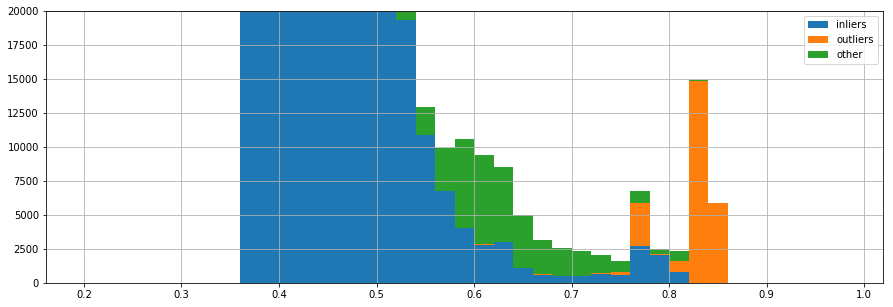

psd[5] psi=1024 50


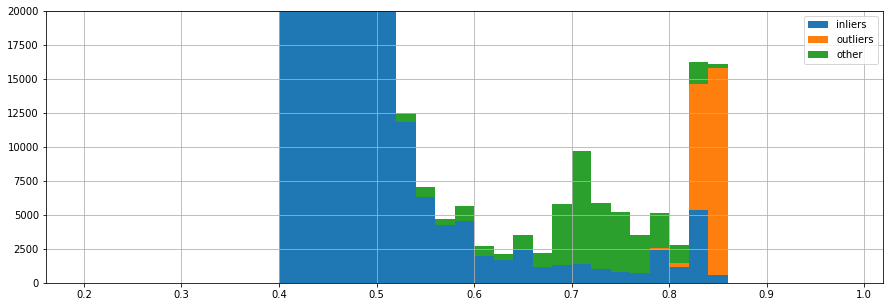

In [101]:
bins = np.arange(0.2, 1, 0.02)
data = {}
# ylims = [1, len(list(preds.values())[0])]

# sel_inlier = allset_train.class_selector[class_inlier]
# sel_outlier = allset_train.class_selector[class_outlier]
# sel_me_suspicious = allset_train.class_selector[class_me_suspicious]
# sel_me_unknown = allset_train.class_selector[class_me_unknown]

print('SCORES DISTRIBUTIONS ON SEGMENTS: ME ONLY (AFTER RE-LABELLING)')

for name, pred_df in me_preds.items():
    data[name] = {
        'inliers': pred_df[sel_inlier(pred_df)].predicted_anomaly_score,
        'outliers': pred_df[sel_outlier(pred_df)].predicted_anomaly_score,
        'other': pred_df[(~sel_inlier(pred_df)) & (~sel_outlier(pred_df))].predicted_anomaly_score
    }

with plotparams({'figure.figsize': (15, 5)}):
    for name, data_ in data.items():
        print(name)
        plt.hist(data_.values(), bins=bins, log=False, histtype='bar', stacked=True, label=data_.keys())
        plt.grid()
        plt.ylim([0, 20000])
        plt.legend()
        plt.show()

In [85]:
from sod.core import pdconcat
print('Setting station ids with outliers')
s_preds = {}
for name, pred_df in preds.items():
    preds__ = []
    for (sta_id, ds_id), df_ in pred_df.groupby(['station_id', 'dataset_id'], sort=False):
        df_row = df_[:1].copy()
        df_row.predicted_anomaly_score = df_.predicted_anomaly_score.median()
        assert df_.outlier.all() or (~df_.outlier.any())
        preds__.append(df_row)
    s_preds[name] = pdconcat(preds__)

print_cm(s_preds)

Setting station ids with outliers
psd[.2,1,2,5] psi=4096 t=50
MEAN LOG LOSS (weighted): 0.381
MEAN ACCURACY (% RECOGNITION, weighted): 99.027
                     ok  outlier  % rec.  Mean log_loss
ok                 2760       16  99.424        0.53781
outl. (wrong inv)     1       72  98.630        0.22335

psd[5] psi=1024 50
MEAN LOG LOSS (weighted): 0.380
MEAN ACCURACY (% RECOGNITION, weighted): 98.792
                     ok  outlier  % rec.  Mean log_loss
ok                 2747       29  98.955        0.57011
outl. (wrong inv)     1       72  98.630        0.18945



In [ ]:
# STO PHERE STOP HERE !!!!



ROC curves


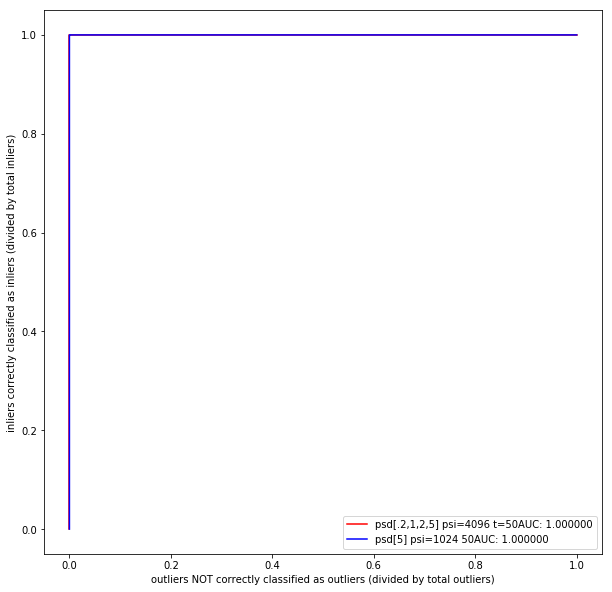

In [48]:
from sklearn.metrics import roc_curve, auc

colors = cycle(['r-', 'b-', 'g-', 'y-', 'm-', 'k-'])
with plotparams({'figure.figsize': (10, 10)}):
    for name, prd_df in preds.items():
        
        k = 'score_samples'
#         print('\n%s values of score samples (0 ok, 1=anomaly)' % str(name))
#         data = []
#         for cname, class_selector in classes.items():
#             _prd_df = prd_df[class_selector(prd_df)]
#             data.append((_prd_df[k].min(), _prd_df[k].median(), _prd_df[k].max()))
#         print(pd.DataFrame(data, columns=['min', 'median', 'max'], index=list(classes.keys())))

        roc_df = prd_df
        fpr, tpr, thresholds = roc_curve(roc_df['outlier'] * 1.0, roc_df['predicted_anomaly_score'])
        _ = next(colors)
        plt.plot(fpr, tpr, color=_[0], label=name + 'AUC: %f' % auc(fpr, tpr))
        # mxx = np.argmax(fpr*(1.0-tpr))
        # print('%s' % str([fpr[mxx], tpr[mxx]]))
        #plt.scatter(fpr[mxx], tpr[mxx], color=_[0])

    print('\nROC curves')

    plt.ylabel('inliers correctly classified as inliers (divided by total inliers)')
    plt.xlabel('outliers NOT correctly classified as outliers (divided by total outliers)')
    plt.legend()
    plt.show()

In [17]:
from sod.core import pdconcat

spreds = {}  # station predictions dataframes

groupcols = ['cha_id', 'dataset_id', 'station_id', 'location_code']
added_cols = ['subclass', 'outlier', 'score_samples', 'decision_function', 'num segs']

print('Creating stations prediction dataframes')
print(groupcols)

for name, prd_df in preds.items():
    prd_df = select(prd_df, classes)
    data = []
    for colz_vals, df in prd_df.groupby(groupcols):
        if df.empty:
            continue
        row = list(colz_vals)
        zum = df['outlier'].sum()
        assert zum == 0 or zum == len(df)
        assert len(pd.unique(df['subclass'])) == 1
        row += [df.iloc[0]['subclass'], df.iloc[0]['outlier'],
                df.score_samples.median(), df.decision_function.median(), len(df)]
        data.append(row)
    spreds[name] = pd.DataFrame(data, columns = groupcols + added_cols)
    # spreds[name] = pdconcat(data)
print('Done')

Creating stations prediction dataframes
['cha_id', 'dataset_id', 'station_id', 'location_code']
Done



CONFUSION MATRICES AT STATION LEVEL


psd[2,5] 0.1 512 | conf. matrx
                                 total  correctly predicted  mean log loss
outl. (wrong inv)                   57                   56       0.110202
unlabeled (Me suspicious outl.)     17                    7       0.308632
unlabeled (Me unknown)            2330                 2216       0.252363

psd[2,5] 0.05 2048 | conf. matrx
                                 total  correctly predicted  mean log loss
outl. (wrong inv)                   57                   56       0.115404
unlabeled (Me suspicious outl.)     17                    6       0.318409
unlabeled (Me unknown)            2330                 2226       0.246677

psd[5] 0.05 512 | conf. matrx
                                 total  correctly predicted  mean log loss
outl. (wrong inv)                   57                   56       0.102809
unlabeled (Me suspicious outl.)     17                    7       0.285931
unlabeled (Me unknown)            2330  

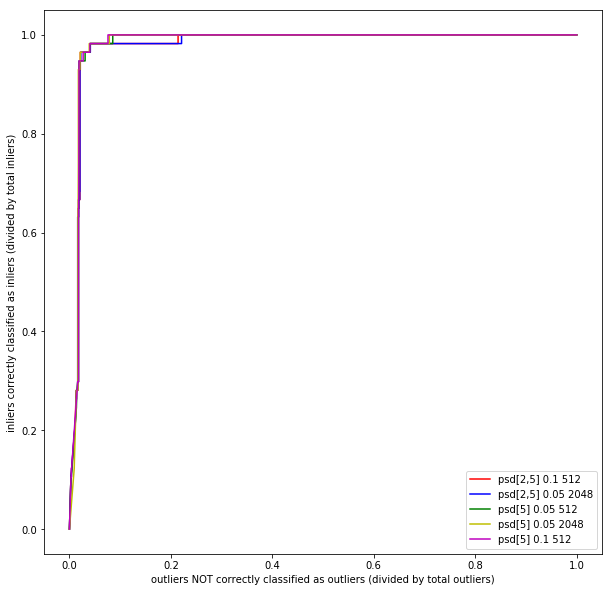

In [18]:
# from sklearn.metrics.log_loss
print('\nCONFUSION MATRICES AT STATION LEVEL\n')
for name, prd_df in spreds.items():

    k = 'score_samples'
    print('\n%s | conf. matrx' % str(name))
    data = []
    for cname, class_selector in classes.items():
        _prd_df = prd_df[class_selector(prd_df)]
        expected_class = _prd_df['outlier'].astype(float)
        if (expected_class == 1).all():
            correctly_predicted = _prd_df['score_samples'] >= 0.5
        elif (expected_class == 0).all():
            correctly_predicted = _prd_df['score_samples'] < 0.5
        else:
            raise ValueError('mixing expected classes for class %s' % cname)
        assert not np.isnan(expected_class).any()
        assert not np.isnan(correctly_predicted).any()
        assert not np.isnan(_prd_df['score_samples']).any()
        log_loss = -np.log10(np.clip(1 - np.abs(expected_class - _prd_df['score_samples']), 1e-15, 1-1e-15))
        # when expected == predicted => log_loss = 1
        # when expected=1 and predicted=0 (or viceversa) => log_loss = 0
        
        # log_loss = np.log10(log_loss)
        # print(log_loss)
        data.append([len(_prd_df), correctly_predicted.sum(), log_loss.mean()])
    print(pd.DataFrame(data, columns=['total', 'correctly predicted', 'mean log loss'], index=list(classes.keys())))




colors = cycle(['r-', 'b-', 'g-', 'y-', 'm-', 'k-'])
with plotparams({'figure.figsize': (10, 10)}):
    for name, prd_df in spreds.items():
        
        k = 'score_samples'
#         print('\n%s values of score samples (0 ok, 1=anomaly)' % str(name))
#         data = []
#         for cname, class_selector in classes.items():
#             _prd_df = prd_df[class_selector(prd_df)]
#             data.append((_prd_df[k].min(), _prd_df[k].median(), _prd_df[k].max()))
#         print(pd.DataFrame(data, columns=['min', 'median', 'max'], index=list(classes.keys())))

        roc_df = select(prd_df, rc_classes)
        fpr, tpr, thresholds = roc_curve(roc_df['outlier'] * 1.0, roc_df['score_samples'])
        _ = next(colors)
        plt.plot(fpr, tpr, color=_[0], label=name)
        # mxx = np.argmax(fpr*(1.0-tpr))
        # print('%s' % str([fpr[mxx], tpr[mxx]]))
        #plt.scatter(fpr[mxx], tpr[mxx], color=_[0])

    print('\nROC curves (only using classes: %s)' % str(rc_classnames))

    plt.ylabel('inliers correctly classified as inliers (divided by total inliers)')
    plt.xlabel('outliers NOT correctly classified as outliers (divided by total outliers)')
    plt.legend()
    plt.show()

In [19]:
colors = cycle(['r-', 'b-', 'g-', 'y-', 'm-', 'k-'])
from collections import defaultdict
# unique station keys mapped to the classifier names for which the station is misclassified:
# many_wrong = defaultdict(list)
# for name, prd_df in spreds.items():   
#     prd_df_msclf = prd_df[prd_df.outlier != (prd_df.score_samples > 0.5)]
#     for data in zip(*[prd_df_msclf[_] for _ in groupcols]):
#         many_wrong[data].append(name)
#         print(data)
#         raise
#     print('\n\n%s: %d misclassified (0 ok, 1=anomaly)\n' % (str(name), len(prd_df_msclf)))
#     print(prd_df_msclf.to_string(index=False))

for name, prd_df in spreds.items():   
    prd_df_msclf = prd_df[prd_df.outlier != (prd_df.score_samples > 0.5)]
    print('\n\n%s: %d misclassified (score_samples: 0=ok, 1=anomaly)\n' % (str(name), len(prd_df_msclf)))
    prd_df_msclf.drop(['decision_function'], 1, inplace=True)
    print(prd_df_msclf.sort_values(by=['subclass', 'score_samples']).to_string(index=False))



psd[2,5] 0.1 512: 125 misclassified (score_samples: 0=ok, 1=anomaly)

cha_id  dataset_id  station_id location_code                 subclass  outlier  score_samples  num segs
   BH           2        3258                                            True       0.433563       712
   BH           2        3246                unlabeled.maybe.outlier     True       0.408503      1071
   BH           2         434                unlabeled.maybe.outlier     True       0.409318       665
   BH           2        3242                unlabeled.maybe.outlier     True       0.409742       601
   BH           2        1126                unlabeled.maybe.outlier     True       0.410985      2463
   BH           2        3225                unlabeled.maybe.outlier     True       0.411132       855
   BH           2        2893                unlabeled.maybe.outlier     True       0.422111       507
   BH           2        1210                unlabeled.maybe.outlier     True       0.425650      2607


JUST A TRY WITH FAKE DATA


ROC curves classifier with better REC RATE, worst scores


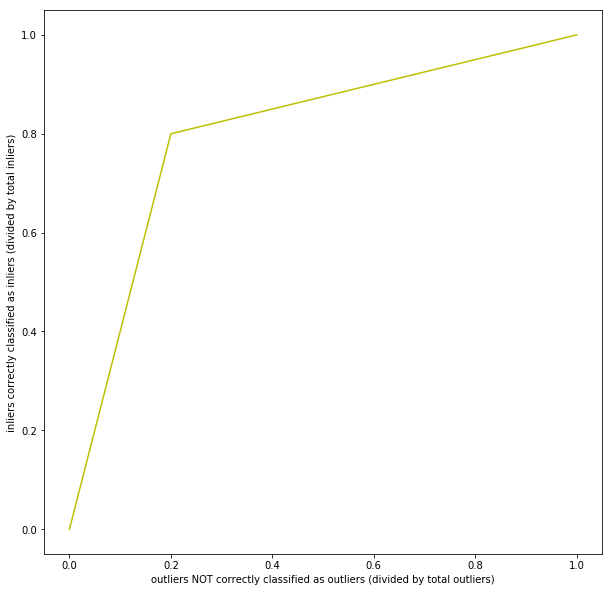


ROC curves classifier with worse REC RATE, better scores


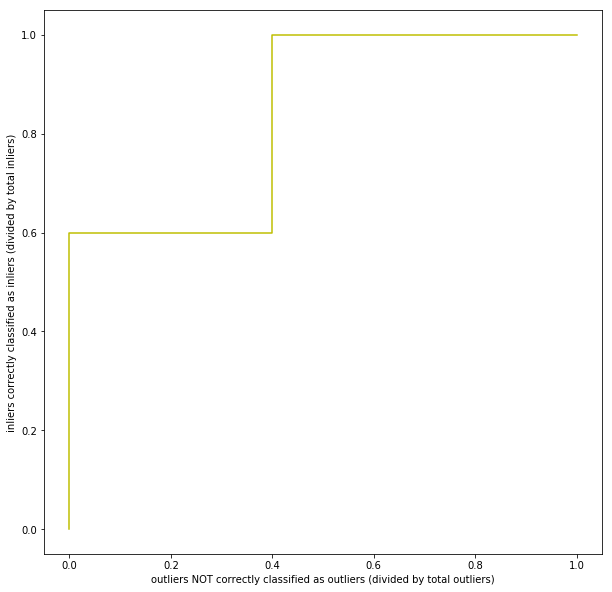

In [12]:
# let's make a try:
y_true = [-1, -1, -1, -1, -1, 1, 1, 1, 1, 1]
y_pred = [0] * 4 + [1, 0] + [1]*4

print('JUST A TRY WITH FAKE DATA\n')
with plotparams({'figure.figsize': (10, 10)}):

    print('\nROC curves classifier with better REC RATE, worst scores')
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    plt.plot(fpr, tpr, color=_[0])
    plt.ylabel('inliers correctly classified as inliers (divided by total inliers)')
    plt.xlabel('outliers NOT correctly classified as outliers (divided by total outliers)')
    plt.show()

y_true = [-1, -1, -1, -1, -1, 1, 1, 1, 1, 1]
y_pred = [0] * 3 + [0.6, 0.6, 0.4, 0.4] + [1] * 3

with plotparams({'figure.figsize': (10, 10)}):

    print('\nROC curves classifier with worse REC RATE, better scores')
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    plt.plot(fpr, tpr, color=_[0])
    plt.ylabel('inliers correctly classified as inliers (divided by total inliers)')
    plt.xlabel('outliers NOT correctly classified as outliers (divided by total outliers)')
    plt.show()

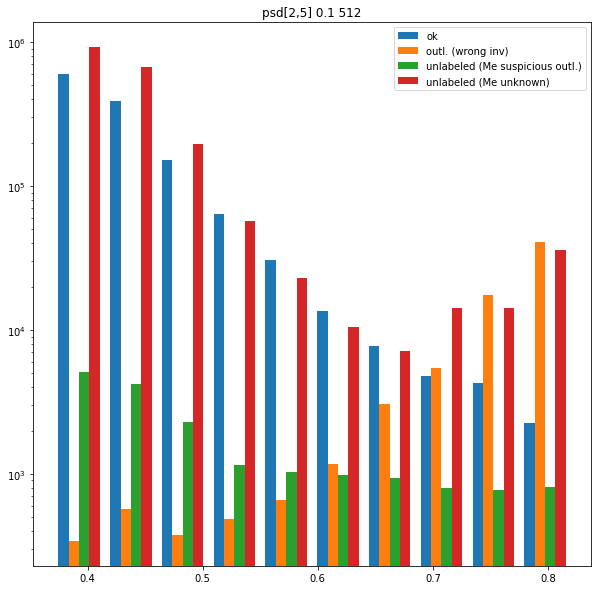

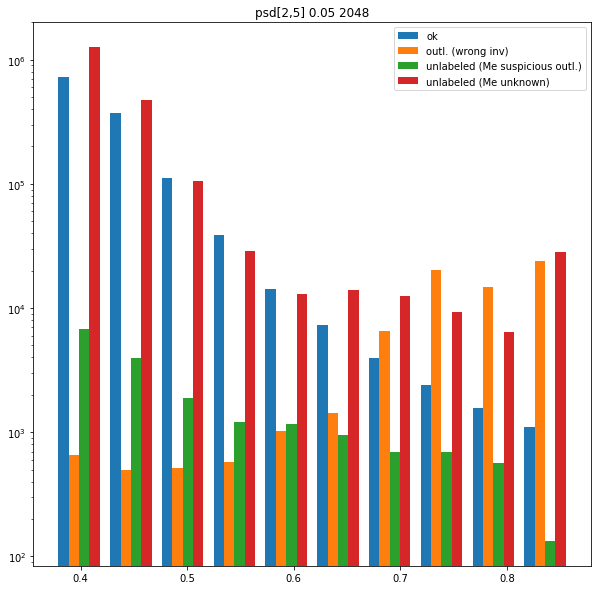

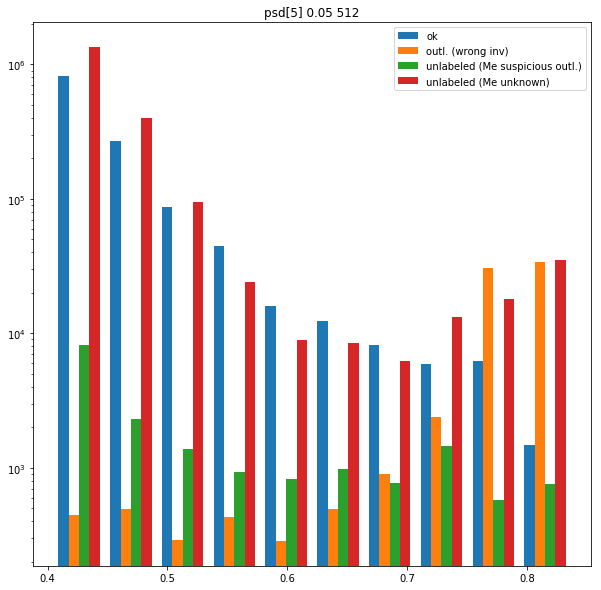

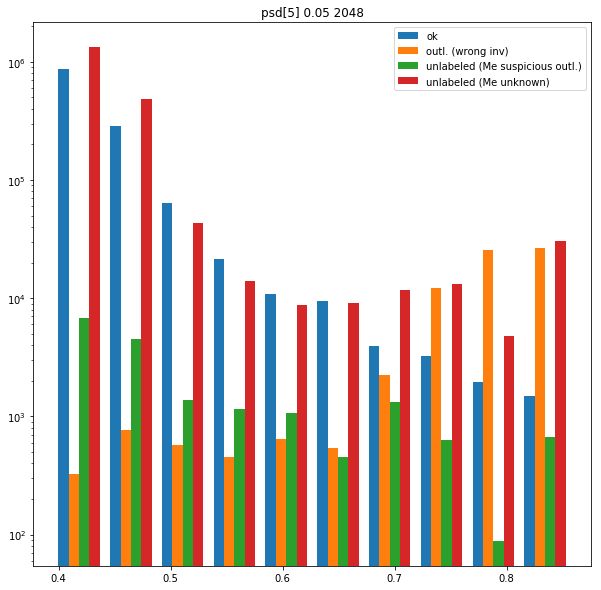

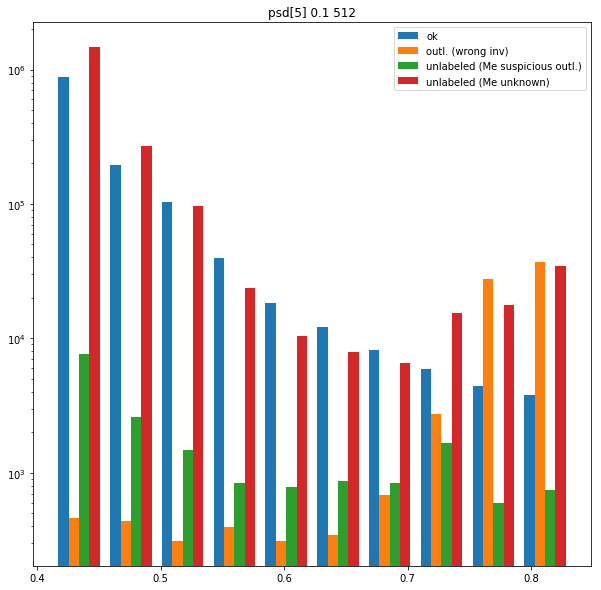

In [20]:
classnames = sod_core_dataset.allset_train.classnames
classes = {_: sod_core_dataset.allset_train.class_selector[_] for _ in classnames}

with plotparams({'figure.figsize': (10, 10)}):
    for name, prd_df in preds.items():
        data = []
        for cname, csel in classes.items():
            data.append(prd_df[csel(prd_df)]['score_samples'])
        plt.hist(data, stacked=False, log=True)  #
        plt.title(name)
        plt.legend(list(classnames))
        plt.show()
#         prd_df_msclf = prd_df[prd_df.outlier != (prd_df.score_samples > 0.5)]
#         print('\n\n%s: %d misclassified (score_samples: 0=ok, 1=anomaly)\n' % (str(name), len(prd_df_msclf)))
#         prd_df_msclf.drop(['decision_function'], 1, inplace=True)
#         print(prd_df_msclf.sort_values(by=['subclass', 'score_samples']).to_string(index=False))

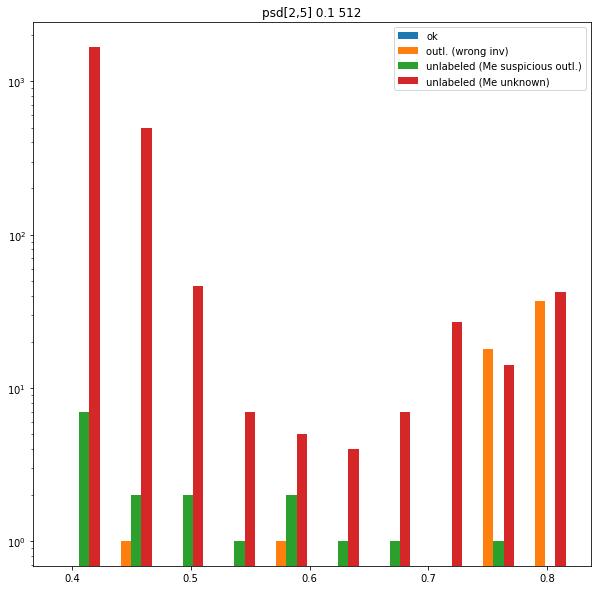

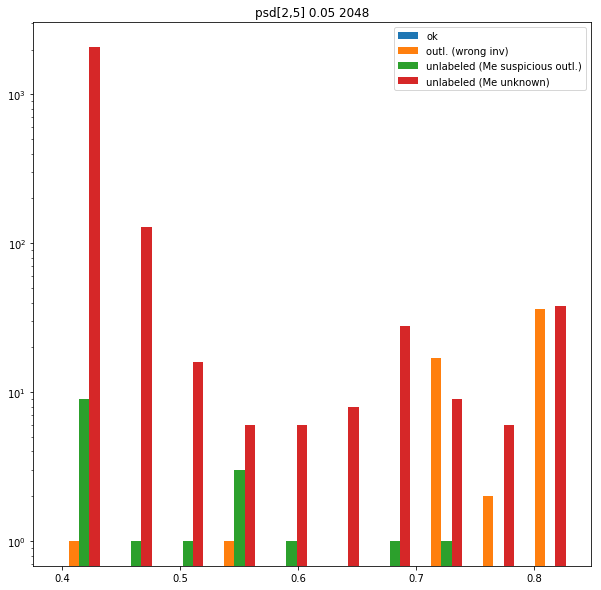

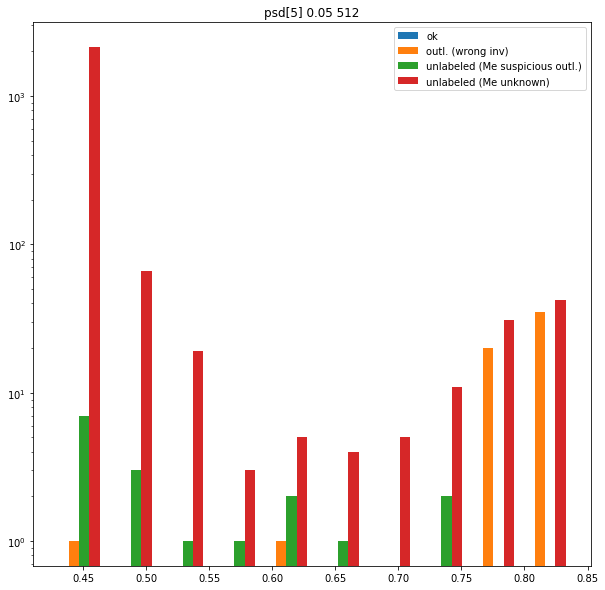

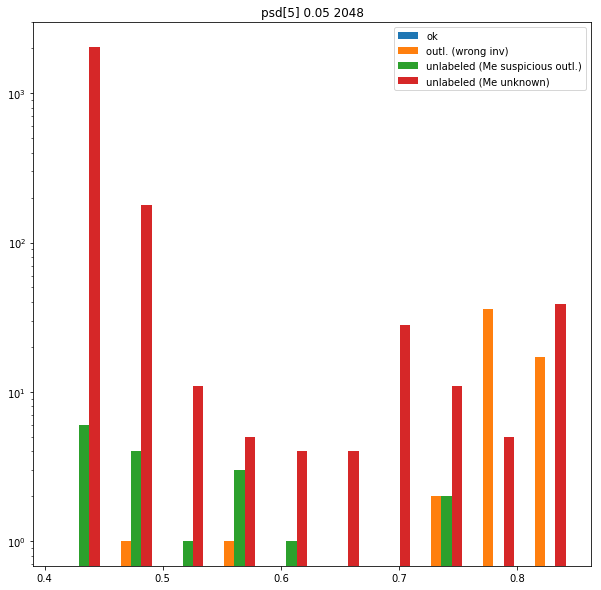

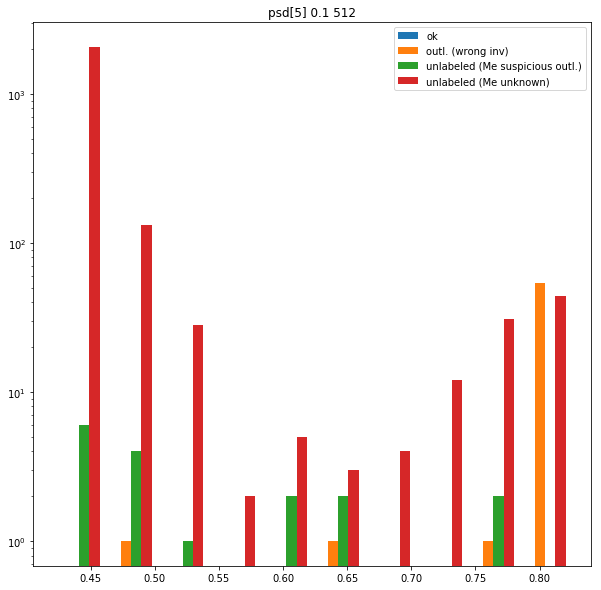

In [21]:
classnames = sod_core_dataset.allset_train.classnames
classes = {_: sod_core_dataset.allset_train.class_selector[_] for _ in classnames}

with plotparams({'figure.figsize': (10, 10)}):
    for name, prd_df in spreds.items():
        data = []
        for cname, csel in classes.items():
            data.append(prd_df[csel(prd_df)]['score_samples'])
        plt.hist(data, stacked=False, log=True)  #
        plt.title(name)
        plt.legend(list(classnames))
        plt.show()


Performances

Estimating performances


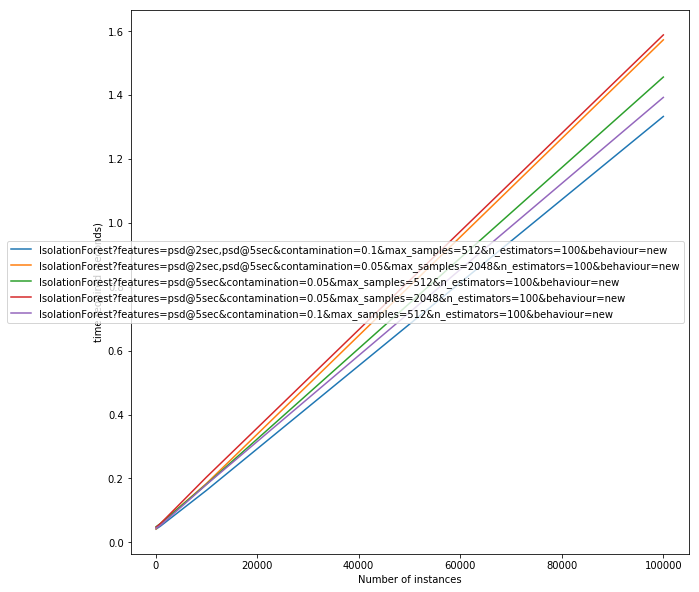

In [23]:
# adding now the two best overall:
import time
from sod.core.evaluation import _predict
# clfs = {k: load(os.path.join(root, 'models', v + '.model')) for k, v in fnames.items()}


with plotparams({'figure.figsize': (10, 10)}):

    print('\nPerformances')

    numinst = (100, 1000, 10000, 100000)
    dfs = {_: dataframe.iloc[np.random.randint(0, len(dataframe), _)].dropna() for _ in numinst}
    print('\nEstimating performances')
    for name, clf in clfs.items():
        feats = fnames[name]
        feats = feats[feats.find('features=') + len('features='):].split('&')[0].split(',')
        # print(feats)
        plotdata = []
        for test in numinst:
            ints = np.random.randint(0, len(dataframe), test)
            # dataf = dataframe.iloc[ints]
            test_df = dfs[test][feats]
            t = time.time()
            #print(dataf[feats])
            # raise
            prd = _predict(clf, test_df)
            t = time.time() - t
            plotdata.append(t)
        plt.plot(numinst, plotdata, label=fnames[name])
    plt.xlabel('Number of instances')
    plt.ylabel('time required (seconds)')
    plt.legend()
plt.show()



In [ ]:
# fare un boxplot asse x: tempo, asse y: score_samples